In [7]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import sqlite3
import os
from datetime import datetime, timedelta
import time
import uuid
import logging
import pandas as pd
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(filename='pothole_detection.log', level=logging.INFO)

# Load the trained model
model = YOLO('best.pt')  # Specify the path to your model weights

# Create directories to store pothole frames
if not os.path.exists('pothole_frames'):
    os.makedirs('pothole_frames')

# Force close any existing connections and create a new one
try:
    conn = sqlite3.connect('potholes.db', timeout=10, isolation_level=None, uri=True)
    conn.execute('PRAGMA query_only = ON;')
    conn.close()
except sqlite3.OperationalError:
    print("Could not access the database. It might be locked or doesn't exist.")

# Now create a new connection
conn = sqlite3.connect('potholes.db')
c = conn.cursor()

# Drop the existing table if it exists
c.execute('DROP TABLE IF EXISTS potholes')

# Create table with the new structure
c.execute('''CREATE TABLE potholes
             (id INTEGER PRIMARY KEY AUTOINCREMENT,
              frame_number INTEGER,
              timestamp TEXT,
              image_path TEXT,
              very_big_count INTEGER,
              big_count INTEGER,
              medium_count INTEGER,
              small_count INTEGER,
              very_small_count INTEGER,
              central_count INTEGER,
              sided_count INTEGER,
              out_of_road_count INTEGER,
              gravity_score REAL)''')

# Define source points for the perspective transform
def get_src_points(img):
    height, width = img.shape[:2]
    return np.float32([
        [0, height],          # Bottom-left point
        [width, height],      # Bottom-right point
        [width, 0],           # Top-right point
        [0, 0]                # Top-left point
    ])

# Define destination points for the perspective transform
def get_dst_points(width, height):
    return np.float32([
        [width*0.05, height],    # Bottom-left point
        [width*0.95, height],    # Bottom-right point
        [width*0.75, 0],         # Top-right point
        [width*0.25, 0]          # Top-left point
    ])

# Function to apply a lighter bird's eye view transformation
def bird_eye_transform(img):
    height, width = img.shape[:2]
    src_points = get_src_points(img)
    dst_points = get_dst_points(width, height)
    
    # Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # Apply the perspective transformation
    bird_eye_view = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    
    return bird_eye_view

# Define size thresholds and colors
def get_size_category(area, frame_area):
    ratio = area / frame_area
    if ratio > 0.05:  # Reduced from 0.25
        return "Very Big", (255, 0, 0)  # Blue
    elif ratio > 0.02:  # Reduced from 0.1
        return "Big", (0, 255, 0)  # Green
    elif ratio > 0.005:  # Reduced from 0.01
        return "Medium", (0, 255, 255)  # Yellow
    elif ratio > 0.0005:  # Reduced from 0.001
        return "Small", (0, 165, 255)  # Orange
    else:
        return "Very Small", (0, 0, 255)  # Red

# Function to determine position on the road
def get_road_position(x, frame_width):
    ratio = x / frame_width
    if ratio < 0.1 or ratio > 0.9:  # Changed from 0.2 and 0.8
        return "Out of Road"
    elif 0.45 <= ratio <= 0.55:  # Changed from 0.4 and 0.6
        return "Central"
    else:
        return "Sided"

# Function to draw bounding boxes on the image
def draw_boxes(img, boxes, labels, confidences, frame_number, timestamp):
    frame_area = img.shape[0] * img.shape[1]
    frame_width = img.shape[1]
    frame_pothole_counts = {"Very Big": 0, "Big": 0, "Medium": 0, "Small": 0, "Very Small": 0}
    frame_position_counts = {"Central": 0, "Sided": 0, "Out of Road": 0}
    
    for box, label, conf in zip(boxes, labels, confidences):
        if conf > 0.2:  # Increased confidence threshold
            x, y, w, h = box
            area = w * h
            size_category, color = get_size_category(area, frame_area)
            position = get_road_position(x, frame_width)
            
            x_min, y_min = int(x - w / 2), int(y - h / 2)
            x_max, y_max = int(x + w / 2), int(y + h / 2)
            
            # Draw potholes with thicker lines and different colors based on size
            if size_category == "Very Big":
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 6)
            elif size_category == "Big":
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 5)
            elif size_category == "Medium":
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 4)
            elif size_category == "Small":
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 3)
            else:  # Very Small
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
            
            # Add text label for size category
            cv2.putText(img, size_category, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            frame_pothole_counts[size_category] += 1
            frame_position_counts[position] += 1
    
    return img, frame_pothole_counts, frame_position_counts

# Function to calculate gravity score
def calculate_gravity_score(pothole_counts, position_counts):
    size_weights = {"Very Big": 5, "Big": 4, "Medium": 3, "Small": 2, "Very Small": 1}
    position_weights = {"Central": 3, "Sided": 2, "Out of Road": 1}
    
    size_score = sum(count * size_weights[size] for size, count in pothole_counts.items())
    position_score = sum(count * position_weights[pos] for pos, count in position_counts.items())
    
    total_potholes = sum(pothole_counts.values())
    if total_potholes == 0:
        return 0
    
    return (size_score + position_score) / total_potholes

# Function to display cumulative counts, timestamp, FPS, and estimated speed on the image
def display_info(img, cumulative_pothole_counts, cumulative_position_counts, timestamp, fps, estimated_speed):
    # Create a semi-transparent overlay
    overlay = img.copy()
    cv2.rectangle(overlay, (0, 0), (img.shape[1], 150), (0, 0, 0), -1)
    cv2.rectangle(overlay, (img.shape[1]-300, 0), (img.shape[1], 150), (0, 0, 0), -1)
    cv2.rectangle(overlay, (0, img.shape[0]-100), (img.shape[1], img.shape[0]), (0, 0, 0), -1)
    
    # Apply the overlay
    cv2.addWeighted(overlay, 0.5, img, 0.5, 0, img)

    # Display cumulative pothole counts on the image
    total_potholes = sum(cumulative_pothole_counts.values())
    cv2.putText(img, f'Total Potholes: {total_potholes}', (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)  # White text
    y_offset = 60
    for size, count in cumulative_pothole_counts.items():
        cv2.putText(img, f'{size}: {count}', (10, y_offset), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)  # White text
        y_offset += 30
    
    # Display cumulative position counts on the upper right corner
    y_offset = 30
    for position, count in cumulative_position_counts.items():
        text = f'{position}: {count}'
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        x_offset = img.shape[1] - text_size[0] - 10
        cv2.putText(img, text, (x_offset, y_offset), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)  # White text
        y_offset += 30
    
    # Display timestamp at the bottom of the frame
    cv2.putText(img, timestamp, (10, img.shape[0] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)  # White text
    
    # Display FPS
    cv2.putText(img, f'FPS: {fps:.2f}', (10, img.shape[0] - 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)  # White text
    
    # Display estimated speed
    cv2.putText(img, f'Est. Speed: {estimated_speed:.2f} km/h', (10, img.shape[0] - 90), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)  # White text
    
    return img

# Open the video file
cap = cv2.VideoCapture('VID_20240926_155553.mp4')  # Replace with your video path

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Error checking for fps
if fps <= 0:
    print("Warning: Invalid FPS. Setting to default value of 30.")
    fps = 30

# Create VideoWriter objects
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_original = cv2.VideoWriter('output_video_original.mp4', fourcc, fps, (frame_width, frame_height))
out_bird_eye = cv2.VideoWriter('output_video_bird_eye.mp4', fourcc, fps, (frame_width, frame_height))

# Get the video duration and calculate timestamps
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
video_duration = total_frames / fps
start_time = datetime.now()

# Variables for FPS calculation
prev_frame_time = 0

# Assume the average width of a road lane is 3.7 meters
LANE_WIDTH_METERS = 3.7

# Speed thresholds (in km/h)
SPEED_THRESHOLDS = [10, 20, 30]

# Set process interval (process a frame every 2 seconds)
process_interval = int(2 * fps)

# Function to estimate speed based on thresholds
def estimate_speed(pixels_moved, fps, pixels_per_meter):
    if fps == 0:
        return 0
    meters_per_second = (pixels_moved / pixels_per_meter) * fps
    km_per_hour = meters_per_second * 3.6
    
    for threshold in SPEED_THRESHOLDS:
        if km_per_hour <= threshold:
            return threshold
    
    return SPEED_THRESHOLDS[-1]

# Read the video frame by frame
frame_count = 0
cumulative_pothole_counts = {"Very Big": 0, "Big": 0, "Medium": 0, "Small": 0, "Very Small": 0}
cumulative_position_counts = {"Central": 0, "Sided": 0, "Out of Road": 0}
prev_frame = None
last_processed_frame = None
last_processed_bird_eye = None

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Can't receive frame (stream end?). Exiting ...")
        break

    frame_count += 1
    
    # Process one frame every 2 seconds
    if frame_count % process_interval == 0:
        # Calculate current timestamp
        current_time = start_time + timedelta(seconds=(frame_count / fps))
        timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")

        # Calculate FPS
        new_frame_time = time.time()
        if prev_frame_time != 0:
            fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time

        # Estimate speed
        pixels_per_meter = frame.shape[1] / LANE_WIDTH_METERS
        if prev_frame is not None:
            frame_diff = cv2.absdiff(frame, prev_frame)
            pixels_moved = np.sum(frame_diff) / 255
            estimated_speed = estimate_speed(pixels_moved, fps, pixels_per_meter)
        else:
            estimated_speed = 0
        prev_frame = frame.copy()

        # Perform inference on the original frame
        results = model(frame, conf=0.3)
        
        for r in results:
            boxes = r.boxes
            if len(boxes) > 0:
                bboxes = boxes.xywh.cpu().numpy()
                scores = boxes.conf.cpu().numpy()
                class_ids = boxes.cls.cpu().numpy().astype(int)
                labels = [model.names[c] for c in class_ids]

                frame, frame_pothole_counts, frame_position_counts = draw_boxes(
                    frame, bboxes, labels, scores, frame_count, timestamp)
                
                # Calculate gravity score for this frame
                frame_gravity_score = calculate_gravity_score(frame_pothole_counts, frame_position_counts)
                
                # Save frame if potholes are detected
                if sum(frame_pothole_counts.values()) > 0:
                    try:
                        frame_id = str(uuid.uuid4())
                        frame_name = f"{timestamp.replace(' ', '_').replace(':', '-')}_{frame_id}"
                        frame_path = os.path.join('pothole_frames', f"{frame_name}.jpg")
                        cv2.imwrite(frame_path, frame)
                        logging.info(f"Saved frame: {frame_path}")
                                                # Insert into database
                        c.execute("""INSERT INTO potholes 
                                    (frame_number, timestamp, image_path, 
                                    very_big_count, big_count, medium_count, small_count, very_small_count,
                                    central_count, sided_count, out_of_road_count, gravity_score) 
                                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""",
                                (frame_count, timestamp, frame_path, 
                                frame_pothole_counts["Very Big"], frame_pothole_counts["Big"], 
                                frame_pothole_counts["Medium"], frame_pothole_counts["Small"], 
                                frame_pothole_counts["Very Small"],
                                frame_position_counts["Central"], frame_position_counts["Sided"], 
                                frame_position_counts["Out of Road"], frame_gravity_score))
                    except Exception as e:
                        logging.error(f"Failed to save frame or insert into database: {e}")
                
                print(f"Frame {frame_count}: Detected {sum(frame_pothole_counts.values())} potholes.")
                print(f"Frame pothole counts: {frame_pothole_counts}")
                print(f"Frame position counts: {frame_position_counts}")
                print(f"Frame gravity score: {frame_gravity_score}")

                # Update cumulative counts
                for size, count in frame_pothole_counts.items():
                    cumulative_pothole_counts[size] += count
                for position, count in frame_position_counts.items():
                    cumulative_position_counts[position] += count
        
        # Display the cumulative counts, timestamp, and other info on the frame
        frame = display_info(frame, cumulative_pothole_counts, cumulative_position_counts, timestamp, fps, estimated_speed)

        # Create bird's eye view (for experimentation only)
        bird_eye_frame = bird_eye_transform(frame)

        last_processed_frame = frame.copy()
        last_processed_bird_eye = bird_eye_frame.copy()

    # Write the frame to the output video (processed or original)
    out_original.write(last_processed_frame if last_processed_frame is not None else frame)
    out_bird_eye.write(last_processed_bird_eye if last_processed_bird_eye is not None else bird_eye_transform(frame))

    # Display the frame in full screen
    cv2.namedWindow('Original View', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty('Original View', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    cv2.imshow('Original View', last_processed_frame if last_processed_frame is not None else frame)

    # Press Q on keyboard to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out_original.release()
out_bird_eye.release()
cv2.destroyAllWindows()

# Commit changes and close the database connection
conn.commit()
conn.close()

print(f"Processed {frame_count} frames")
print("Output videos saved as 'output_video_original.mp4' and 'output_video_bird_eye.mp4'")
print("Pothole database saved as 'potholes.db'")
print("Pothole frames saved in 'pothole_frames' directory")

# Additional analysis and reporting
conn = sqlite3.connect('potholes.db')
df = pd.read_sql_query("SELECT * FROM potholes", conn)
conn.close()

# Calculate total potholes per frame
df['total_potholes'] = df['very_big_count'] + df['big_count'] + df['medium_count'] + df['small_count'] + df['very_small_count']

# Plot total potholes over time
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['total_potholes'])
plt.title('Total Potholes Detected Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Potholes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('potholes_over_time.png')
plt.close()

# Plot distribution of pothole sizes
size_counts = df[['very_big_count', 'big_count', 'medium_count', 'small_count', 'very_small_count']].sum()
plt.figure(figsize=(10, 6))
size_counts.plot(kind='bar')
plt.title('Distribution of Pothole Sizes')
plt.xlabel('Size Category')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('pothole_size_distribution.png')
plt.close()

# Plot distribution of pothole positions
position_counts = df[['central_count', 'sided_count', 'out_of_road_count']].sum()
plt.figure(figsize=(8, 8))
plt.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Pothole Positions')
plt.axis('equal')
plt.tight_layout()
plt.savefig('pothole_position_distribution.png')
plt.close()

# Generate a summary report
with open('pothole_analysis_report.txt', 'w') as f:
    f.write("Pothole Detection Analysis Report\n")
    f.write("================================\n\n")
    f.write(f"Total frames processed: {frame_count}\n")
    f.write(f"Total potholes detected: {df['total_potholes'].sum()}\n\n")
    f.write("Pothole size distribution:\n")
    for size, count in size_counts.items():
        f.write(f"  {size}: {count}\n")
    f.write("\nPothole position distribution:\n")
    for position, count in position_counts.items():
        f.write(f"  {position}: {count}\n")
    f.write(f"\nAverage gravity score: {df['gravity_score'].mean():.2f}\n")
    f.write(f"Max gravity score: {df['gravity_score'].max():.2f}\n")
    f.write(f"Min gravity score: {df['gravity_score'].min():.2f}\n")

print("Analysis complete. Check 'pothole_analysis_report.txt' for a summary.")
print("Graphs saved as 'potholes_over_time.png', 'pothole_size_distribution.png', and 'pothole_position_distribution.png'.")
                


0: 736x1280 1 pothole, 137.4ms
Speed: 11.1ms preprocess, 137.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
Frame 42: Detected 1 potholes.
Frame pothole counts: {'Very Big': 0, 'Big': 0, 'Medium': 0, 'Small': 1, 'Very Small': 0}
Frame position counts: {'Central': 0, 'Sided': 1, 'Out of Road': 0}
Frame gravity score: 4.0

0: 736x1280 (no detections), 134.1ms
Speed: 21.4ms preprocess, 134.1ms inference, 0.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 127.4ms
Speed: 5.5ms preprocess, 127.4ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 125.2ms
Speed: 7.8ms preprocess, 125.2ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 128.6ms
Speed: 7.3ms preprocess, 128.6ms inference, 9.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 121.4ms
Speed: 16.8ms preprocess, 121.4ms inference, 0.0ms postprocess per 

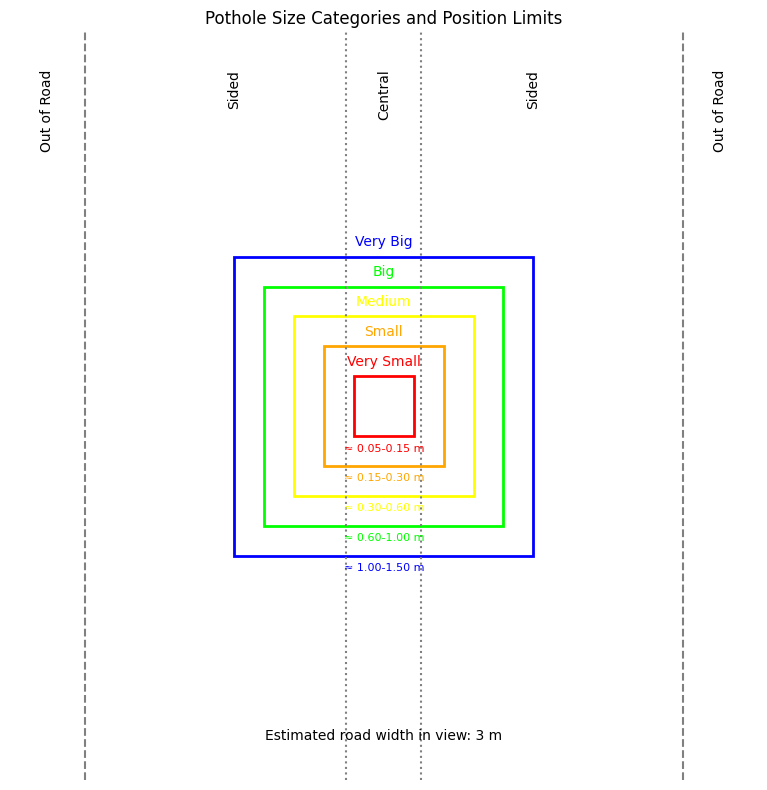

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_and_show_didactic_figure():
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect('equal')

    # Set estimated road width to 3 meters
    road_width = 3  # meters

    # Define size categories, their relative sizes, colors, and estimated diameter ranges
    sizes = [
        ("Very Small", 8, (1, 0, 0), (0.05, 0.15)),   # Red, 5-15 cm
        ("Small", 16, (1, 0.65, 0), (0.15, 0.30)),    # Orange, 15-30 cm
        ("Medium", 24, (1, 1, 0), (0.30, 0.60)),      # Yellow, 30-60 cm
        ("Big", 32, (0, 1, 0), (0.60, 1.00)),         # Green, 60 cm - 1 m
        ("Very Big", 40, (0, 0, 1), (1.00, 1.50))     # Blue, 1-1.5 m
    ]

    # Draw concentric boxes for each size category
    for size, dim, color, (min_diam, max_diam) in reversed(sizes):
        rect = patches.Rectangle((50 - dim/2, 50 - dim/2), dim, dim, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(50, 50 + dim/2 + 1, size, ha='center', va='bottom', fontsize=10, color=color)
        ax.text(50, 50 - dim/2 - 1, f'≈ {min_diam:.2f}-{max_diam:.2f} m', ha='center', va='top', fontsize=8, color=color)

    # Draw position limit lines
    ax.axvline(x=10, color='gray', linestyle='--', label='Out of Road')
    ax.axvline(x=90, color='gray', linestyle='--')
    ax.axvline(x=45, color='gray', linestyle=':', label='Sided')
    ax.axvline(x=55, color='gray', linestyle=':')
    
    # Add labels for position categories
    ax.text(5, 95, 'Out of Road', rotation=90, va='top', ha='center')
    ax.text(95, 95, 'Out of Road', rotation=90, va='top', ha='center')
    ax.text(30, 95, 'Sided', rotation=90, va='top', ha='center')
    ax.text(70, 95, 'Sided', rotation=90, va='top', ha='center')
    ax.text(50, 95, 'Central', rotation=90, va='top', ha='center')

    ax.set_title('Pothole Size Categories and Position Limits')
    ax.text(50, 5, f'Estimated road width in view: {road_width} m', ha='center', va='bottom', fontsize=10)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to create and display the figure
create_and_show_didactic_figure()